In [1]:
import torch
import torch.nn as nn
from transformers import ViTForImageClassification, ViTFeatureExtractor

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=8,  # 8 classes
    ignore_mismatched_sizes=True 
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [2]:
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import random

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = []
        
        for class_idx, class_name in enumerate(os.listdir(img_dir)):
            class_folder = os.path.join(img_dir, class_name)
            if os.path.isdir(class_folder):
                for img_name in os.listdir(class_folder):
                    img_path = os.path.join(class_folder, img_name)
                    self.img_labels.append((img_path, class_idx))
                    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img_dir = '/kaggle/input/microscopic-peripheral-blood-cell-images/PBC_dataset_normal_DIB'  
dataset = CustomImageDataset(img_dir, transform=transform)

dataset_size = len(dataset)
train_size = int(0.01 * dataset_size)
test_val_size = dataset_size - train_size

val_size = int(test_val_size*0.2)
test_size = test_val_size - val_size

train_set, test_val_set = random_split(dataset, [train_size, test_val_size])
val_set, test_set = random_split(test_val_set, [val_size, test_size])

batch_size = 16

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [3]:
import torch.optim as optim
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train(model, train_loader, val_loader, epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc = validate(model, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch+1}/{epochs}] '
              f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% '
              f'| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

def validate(model, val_loader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100. * correct / total
    
    return avg_val_loss, accuracy

In [4]:
train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader, epochs=15)

100%|██████████| 11/11 [00:07<00:00,  1.57it/s]


Epoch [1/15] Train Loss: 1.8290 | Train Acc: 33.53% | Val Loss: 1.3881 | Val Acc: 61.17%


100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


Epoch [2/15] Train Loss: 0.6693 | Train Acc: 82.94% | Val Loss: 0.6894 | Val Acc: 75.21%


100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


Epoch [3/15] Train Loss: 0.1655 | Train Acc: 97.06% | Val Loss: 0.3625 | Val Acc: 89.01%


100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


Epoch [4/15] Train Loss: 0.0458 | Train Acc: 99.41% | Val Loss: 0.5507 | Val Acc: 82.03%


100%|██████████| 11/11 [00:06<00:00,  1.82it/s]


Epoch [5/15] Train Loss: 0.0199 | Train Acc: 100.00% | Val Loss: 0.3086 | Val Acc: 90.69%


100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


Epoch [6/15] Train Loss: 0.0073 | Train Acc: 100.00% | Val Loss: 0.3810 | Val Acc: 88.50%


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Epoch [7/15] Train Loss: 0.0035 | Train Acc: 100.00% | Val Loss: 0.3718 | Val Acc: 89.42%


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Epoch [8/15] Train Loss: 0.0023 | Train Acc: 100.00% | Val Loss: 0.3936 | Val Acc: 89.21%


100%|██████████| 11/11 [00:06<00:00,  1.82it/s]


Epoch [9/15] Train Loss: 0.0019 | Train Acc: 100.00% | Val Loss: 0.3841 | Val Acc: 89.42%


100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


Epoch [10/15] Train Loss: 0.0016 | Train Acc: 100.00% | Val Loss: 0.3710 | Val Acc: 89.69%


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Epoch [11/15] Train Loss: 0.0014 | Train Acc: 100.00% | Val Loss: 0.3666 | Val Acc: 89.83%


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Epoch [12/15] Train Loss: 0.0013 | Train Acc: 100.00% | Val Loss: 0.3659 | Val Acc: 89.86%


100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


Epoch [13/15] Train Loss: 0.0011 | Train Acc: 100.00% | Val Loss: 0.3678 | Val Acc: 89.86%


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Epoch [14/15] Train Loss: 0.0010 | Train Acc: 100.00% | Val Loss: 0.3692 | Val Acc: 90.01%


100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


Epoch [15/15] Train Loss: 0.0009 | Train Acc: 100.00% | Val Loss: 0.3706 | Val Acc: 90.01%


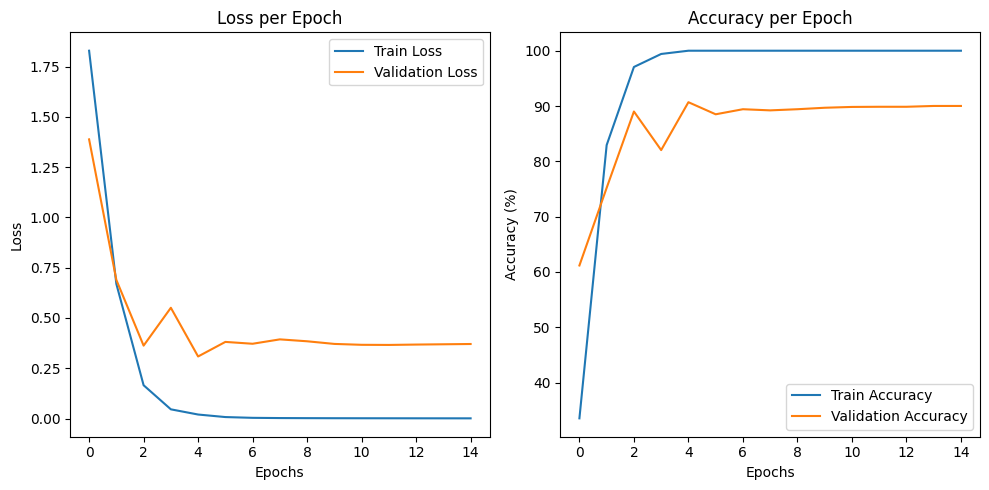

In [5]:
import matplotlib.pyplot as plt
# Plot training and validation loss on the same canvas
plt.figure(figsize=(10, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


In [6]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

# Test the model
test(model, test_loader)

Test Accuracy: 90.36%
